<a href="https://colab.research.google.com/github/maicon-reis/financas_quantitativas/blob/main/Analisando_FIIS_com_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<hr>

## **Web Scrapping de FIIS com Python**

<hr>

In [25]:
# Instalando as libs (Caso necessite instalar as bibliotecas)
#!pip install -q requests
#!pip install -q bs4
# !pip install -q squarify

In [29]:
# Bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import plotly.express as px
import squarify

In [2]:
# Realizando o scraping do site
fii_url = 'https://fundsexplorer.com.br/ranking'
fii_re = requests.get(fii_url)

fii_bs4 = BeautifulSoup(fii_re.text, "html.parser")
fii_table = fii_bs4.findAll(attrs={"id": "scroll-wrapper"})[0].findAll('table')
fii_df = pd.read_html(str(fii_table[0]))[0]

In [3]:
# Criando uma lista com os tickers dos FIIS
fii_lista = fii_df['Códigodo fundo'].to_list()

print(f'Foram coletados  {len(fii_lista)} FIIS no ranking do site Funds Explorer.')

Foram coletados  282 FIIS no ranking do site Funds Explorer.


In [4]:
# Eliminando colunas com mais de 50% de valores faltantes
fii_isna = dict(fii_df.isna().sum() / fii_df.shape[0] * 100)

for k, v in fii_isna.items():
    if fii_isna[k] > 50:
        fii_df.drop(k, axis=1, inplace=True)

In [5]:
# Renomeando as colunas
fii_df.columns = ['codigo_fundo', 'Setor', 'preco_atual', 'liquidez_diaria',
       'dividendo', 'dividend_yield', 'dy_3m_acum', 'dy_6m_acum',
       'dy_12m_acum', 'dy_3m_media', 'dy_6m_media', 'dy_12m_media', 'DY Ano',
       'var_preco', 'Rent_periodo', 'rent_acum', 'patr_liq', 'vpa', 'p_vpa', 
       'dy_patr', 'var_patr', 'rent_patr_no_per', 'rent_patr_acum', 'qtd_ativos']

In [6]:
# Tratamento dos dados 
fii_df = fii_df.replace(to_replace=r'^R\$ ', value='', regex=True)
fii_df = fii_df.replace(to_replace=r'%$', value='', regex=True)

fii_df['preco_atual'] = fii_df['preco_atual'].str.replace('.', '')
fii_df['patr_liq'] = fii_df['patr_liq'].str.replace('.', '')
fii_df['vpa'] = fii_df['vpa'].str.replace('.', '')

colunas = ['preco_atual', 'dividendo', 'dividend_yield', 'dy_3m_acum', 
           'dy_6m_acum', 'dy_12m_acum', 'dy_3m_media', 'dy_6m_media',
           'dy_12m_media', 'DY Ano', 'var_preco', 'Rent_periodo', 'rent_acum',
           'patr_liq', 'vpa', 'dy_patr', 'var_patr', 'rent_patr_no_per',
           'rent_patr_acum']

for coluna in colunas:
    fii_df[coluna] = fii_df[coluna].str.replace(',', '.')

In [7]:
fii_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigo_fundo      282 non-null    object 
 1   Setor             278 non-null    object 
 2   preco_atual       274 non-null    object 
 3   liquidez_diaria   274 non-null    float64
 4   dividendo         282 non-null    object 
 5   dividend_yield    276 non-null    object 
 6   dy_3m_acum        276 non-null    object 
 7   dy_6m_acum        276 non-null    object 
 8   dy_12m_acum       276 non-null    object 
 9   dy_3m_media       276 non-null    object 
 10  dy_6m_media       276 non-null    object 
 11  dy_12m_media      276 non-null    object 
 12  DY Ano            262 non-null    object 
 13  var_preco         276 non-null    object 
 14  Rent_periodo      276 non-null    object 
 15  rent_acum         276 non-null    object 
 16  patr_liq          282 non-null    object 
 1

In [8]:
# Modificação do tipo de dado de object para float
for coluna in colunas:
    fii_df[coluna] = fii_df[coluna].astype(float)

In [9]:
# Excluindo os FIIS com dados faltantes.
fii_df.dropna(axis=0, inplace=True)

In [10]:
# Resetando o índice após o tratamento dos dados
fii_df.reset_index(drop=True, inplace=True)

In [11]:
# Verificação dos dados
fii_df.head()

,codigo_fundo,Setor,preco_atual,liquidez_diaria,dividendo,dividend_yield,dy_3m_acum,dy_6m_acum,dy_12m_acum,dy_3m_media,...,Rent_periodo,rent_acum,patr_liq,vpa,p_vpa,dy_patr,var_patr,rent_patr_no_per,rent_patr_acum,qtd_ativos
0,BNFS11,Outros,119.86,249.0,1.42,1.20,3.22,6.37,11.76,1.07,...,-0.07,-2.60,6.941729e+07,99.17,121.0,1.43,0.01,1.44,5.44,18
1,HSML11,Shoppings,79.50,30292.0,0.60,0.74,2.27,4.37,7.72,0.76,...,1.07,9.17,1.479544e+09,93.76,85.0,0.64,-0.06,0.58,1.59,5
2,SHPH11,Shoppings,758.99,8.0,3.35,0.41,1.34,2.81,4.75,0.45,...,0.06,4.60,5.403845e+08,887.40,86.0,0.40,-0.04,0.36,1.30,1
3,SPTW11,Lajes Corporativas,43.89,4357.0,0.40,0.90,2.71,5.30,16.30,0.90,...,0.07,1.30,9.506514e+07,52.87,83.0,0.76,0.06,0.81,3.30,1
4,HUSC11,Outros,94.00,34.0,0.88,0.96,1.98,3.33,7.08,0.66,...,-6.38,-16.03,1.135982e+08,142.96,66.0,0.38,0.18,0.56,1.40,0


In [12]:
# Fazendo a transposição da tabela para fornecer mais uma forma de visualização.
fii_df_transposta = fii_df.transpose()

# Verificando os dados
fii_df_transposta.head()

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,229,230,231,232,233,234
codigo_fundo,BNFS11,HSML11,SHPH11,SPTW11,HUSC11,TEPP11,BLMO11,VTLT11,KISU11,APTO11,...,HSLG11,PLOG11,KNHY11,JFLL11,KNCR11,RNDP11,PLCR11,CXCO11,PATL11,HGRU11
Setor,Outros,Shoppings,Shoppings,Lajes Corporativas,Outros,Lajes Corporativas,Lajes Corporativas,Logística,Títulos e Val. Mob.,Híbrido,...,Logística,Logística,Títulos e Val. Mob.,Residencial,Títulos e Val. Mob.,Títulos e Val. Mob.,Híbrido,Lajes Corporativas,Híbrido,Híbrido
preco_atual,119.86,79.5,758.99,43.89,94,68.31,24800,90.26,7.48,10.07,...,86.15,71.4,104.8,71.31,101.49,380,87.66,77.03,76.05,117.97
liquidez_diaria,249,30292,8,4357,34,3967,4,601,145026,432,...,3817,1753,25587,2212,95444,8,6928,2069,10687,23532
dividendo,1.42,0.6,3.35,0.4,0.88,0.49,17.51,0.83,0.07,0.12,...,0.63,0.75,1.55,0.62,0.97,4.26,1.1,0.73,0.58,0.82


<hr>

## **4. Análises Estatísticas exploratórias do FIIs**
<hr>

#### **Gráfico de Dispersão entre o Preço Atual e o Dividend Yield Acumulado de 12 meses**

In [17]:
# Utiliando sómente a base de dados com FIIs com preço atual menor ou igual a 250
fii_df2 = fii_df[fii_df['preco_atual'] <= 250.00]

fig = px.scatter(fii_df2, x='preco_atual', y='dy_12m_acum', color='Setor')
fig.show()

In [16]:
fii_df2['log_preco_atual'] = np.log(fii_df2['preco_atual'] + 1)

fig = px.scatter(fii_df2, x='log_preco_atual', y='dy_12m_acum', color='Setor')
fig.show()

<ipython-input-16-b5c659c75465>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### **Matriz de Correlação entre os FIIS**

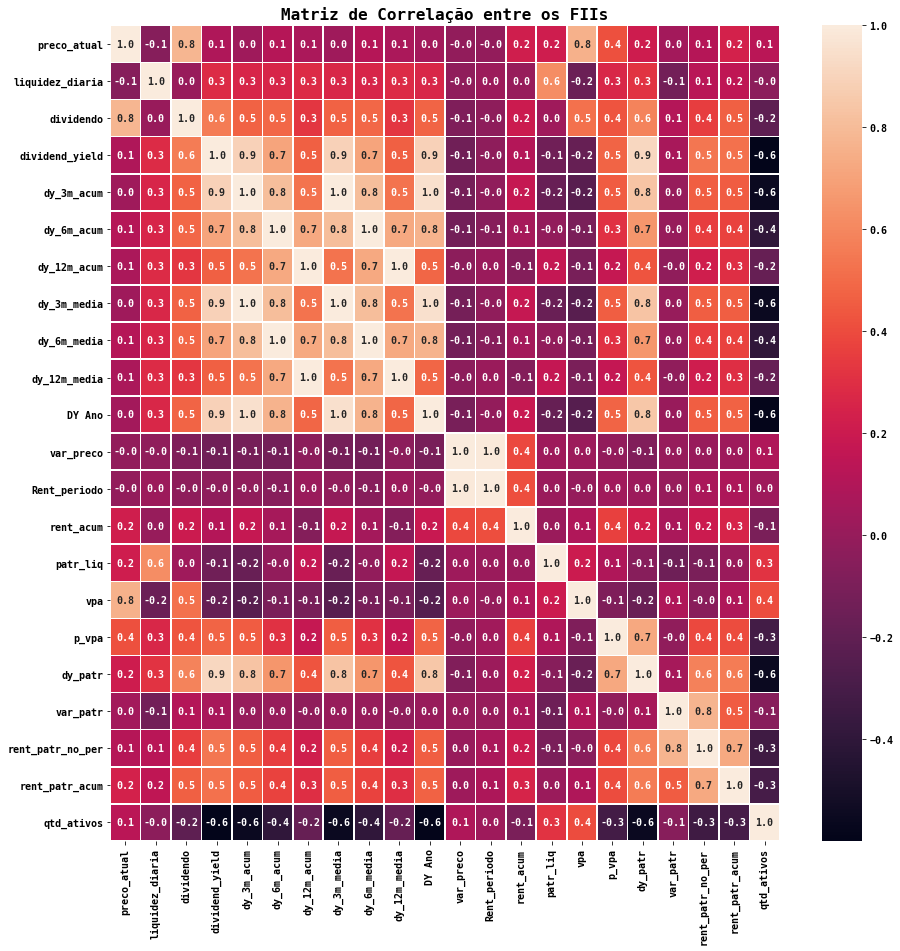

In [22]:
corr_matrix = fii_df.corr(method='spearman')

fig, ax = plt.subplots(figsize=(15,15))
plot = sns.heatmap(corr_matrix, annot=True, fmt='.1f', linewidths=0.7)

font_options = {'family': 'monospace',
                'weight': 'bold'}
plt.rc('font', **font_options)
plt.rcParams.update({'font.size': 10})
titulo_config = {'fontsize': 16, 'fontweight': 'bold', 'color': 'black'}
plt.title('Matriz de Correlação entre os FIIs', **titulo_config)
plt.show()

#### **Média e Mediana do Dividend Yield Acumulado em 12 meses por Setor**

In [23]:
pivot_table_FIIs = pd.pivot_table(fii_df, values='dy_12m_acum', index=['Setor'], columns=[]
                                  , aggfunc=('mean', 'median'))
pivot_table_FIIs.sort_values('mean', ascending=False)

,mean,median
Setor,,
Outros,9.675758,10.110
Títulos e Val. Mob.,8.917209,10.510
Logística,8.192857,8.130
Híbrido,7.543684,8.025
Hotel,7.535000,7.535
Lajes Corporativas,7.470968,7.550
Hospital,6.870000,6.870
Shoppings,5.923684,6.830
Residencial,4.190000,3.675


In [26]:
fii_df['var_patr'] = fii_df['var_patr'] < 100
fii_VPA = fii_df[fii_df['var_patr']]

# Dividen Yield Maior que 10%
fii_VPA_Select = fii_VPA[fii_VPA['dy_12m_acum'] > 12.75][fii_VPA['liquidez_diaria'] > fii_VPA['liquidez_diaria'].median()]
fii_VPA_Select.head()

<ipython-input-26-40fbfdda8d36>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,codigo_fundo,Setor,preco_atual,liquidez_diaria,dividendo,dividend_yield,dy_3m_acum,dy_6m_acum,dy_12m_acum,dy_3m_media,...,Rent_periodo,rent_acum,patr_liq,vpa,p_vpa,dy_patr,var_patr,rent_patr_no_per,rent_patr_acum,qtd_ativos
3,SPTW11,Lajes Corporativas,43.89,4357.0,0.40,0.90,2.71,5.30,16.30,0.90,...,0.07,1.30,9.506514e+07,52.87,83.0,0.76,True,0.81,3.30,1
12,PORD11,Títulos e Val. Mob.,96.30,11835.0,1.41,1.49,3.95,7.54,13.24,1.32,...,2.02,6.72,3.698597e+08,99.20,97.0,1.42,True,1.45,4.92,0
24,HSAF11,Títulos e Val. Mob.,94.33,5512.0,1.15,1.21,3.60,7.00,13.07,1.20,...,0.86,5.57,1.684045e+08,94.95,99.0,1.21,True,1.61,4.24,0
34,VGIP11,Outros,99.40,21774.0,1.50,1.51,4.09,8.54,15.11,1.36,...,0.28,3.92,8.695117e+08,93.56,106.0,1.60,True,-1.33,3.87,0
61,URPR11,Outros,111.95,46599.0,1.84,1.72,4.53,9.11,18.42,1.51,...,-6.89,-5.71,5.495307e+08,99.58,112.0,1.85,True,3.33,11.46,0


#### **Criando um Gráfico de Caixa com os FIIs com Maior DY Acum em 12 meses**

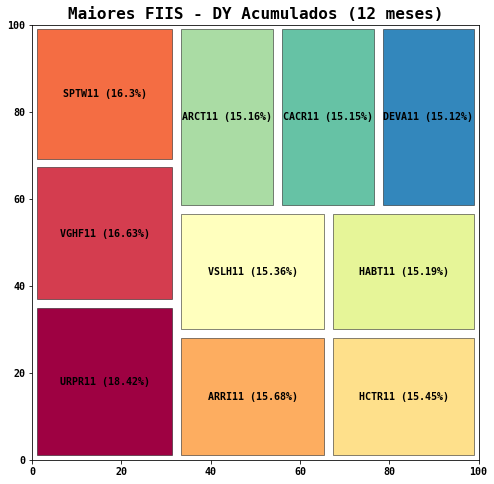

In [32]:
fii_df_10maiores = fii_df.sort_values(by=['dy_12m_acum'], ascending=False).head(10)

labels = fii_df_10maiores['codigo_fundo'].to_list()
sizes = fii_df_10maiores['dy_12m_acum'].astype(float).to_list()
labels_ = list()
for i in range(len(labels)):
    label = f"{labels[i]} ({sizes[i]}%)"
    labels_.append(label)
colors = [plt.cm.Spectral(i/float(len(fii_df_10maiores['codigo_fundo']))) for i in range(len(fii_df_10maiores['codigo_fundo']))]

plt.figure(figsize = (8, 8))
squarify.plot(sizes=sizes
              , label=labels_
              , color=colors
              , bar_kwargs={'linewidth': 0.5, "edgecolor": "#111111"}
              , pad=True)

font_options = {'family': 'monospace',
                'weight': 'bold'}
plt.rc('font', **font_options)
plt.rcParams.update({'font.size': 10})
titulo_config = {'fontsize': 16, 'fontweight': 'bold', 'color': 'black'}
plt.title("Maiores FIIS - DY Acumulados (12 meses)", **titulo_config)
plt.show()